$ \mathcal{Daniel ~H. ~Martínez ~S. ~-~ UdeA ~-~ 2023 } $ \
dhumberto.martinez@udea.edu.co

*References*:
* B. Schaefer et al. “Measuring the Stokes polarization parameters” (2007), doi: [10.1119/1.2386162](https://doi.org/10.1119/1.2386162 "B. Schaefer et al. “Measuring the Stokes polarization parameters” (2007)")
* M. Born and Emil Wolf. "Principles of optics" (2013), Elsevier.

## Explanation
To obtain the polarization states, you need to use a experimental setup consisted of a quarter-wave plate (`QWP`), a linear polarizer (`LP`) and a powermeter. The transmission axis of the `LP` was horizontally fixed, while the `QWP` was rotated from 0° to 180° by steps of N.

## How to use
For a dataframe with minimum N = 8 measurements corresponding to N rotation angles of QWP, the Stokes parameters can be found with this code.

`Test`: Test values contained in `stokes_test()` are given.



S1:  -0.33  Norm
S2:  0.63  Norm
S3:  -0.71  Norm 

E0x:  0.579
E0y:  0.815
psi:  58.86 °
chi:  -22.45 °
delta:  -48.39 °
a:  0.92
b:  -0.38


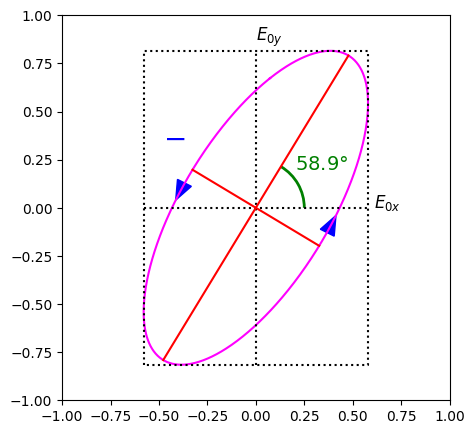

In [15]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from matplotlib import patches

# Fourier coefficients
def A(pow_ang,N=8):
    return (2/N)*pow_ang['Power-Mean (uW)'].sum()
def B(pow_ang,N=8):
    return (4/N)*(pow_ang['Power-Mean (uW)']*np.sin(2*np.pi*pow_ang['QWP angle']/180)).sum()
def C(pow_ang,N=8):
    return (4/N)*(pow_ang['Power-Mean (uW)']*np.cos(4*np.pi*pow_ang['QWP angle']/180)).sum()
def D(pow_ang,N=8):
    return (4/N)*(pow_ang['Power-Mean (uW)']*np.sin(4*np.pi*pow_ang['QWP angle']/180)).sum()
# Stokes parameters
def S0(A,C):
    return A-C
def S1(C):
    return 2*C
def S2(D):
    return 2*D
def S3(B):
    return B
# Polarization ellipse
def Psi(S1,S2):
    psi_aux = np.arctan(S2/S1)
    if (S1<0) & (S2 > 0):
        psi_aux = psi_aux + np.pi
    elif (S1<0) & (S2 < 0):
        psi_aux = psi_aux + np.pi
    elif (S1>0) & (S2 < 0):
        psi_aux = psi_aux + 2*np.pi
    return 0.5*psi_aux
def Chi(S3,S0):
    return 0.5*np.arcsin(S3/S0)
def Delta(S3,S2):
    delta_aux = np.arctan(S3/S2)
    if (S2<0) & (S3 > 0):
        delta_aux = delta_aux + np.pi
    elif (S2<0) & (S3 < 0):
        delta_aux = delta_aux + np.pi
#     elif (S2>0) & (S3 < 0):
#         delta_aux = delta_aux + 2*np.pi
    return delta_aux
def E_0x(S0,S1):
    return np.sqrt(0.5*(S0+S1)/S0)
def E_0y(S0,S1):
    return np.sqrt(0.5*(S0-S1)/S0)

def param_Pol_ellip(df,Normaliz='yes'):
    Norm, unid = 1,' uW'
    s0p, s1, s2, s3 = S0(A(df),C(df)), S1(C(df)), S2(D(df)), S3(B(df))
    s0  = np.sqrt(s1**2+s2**2+s3**2)
    if Normaliz == 'yes':
        Norm = s0
        unid = ' Norm'
    a1, a2, psi, chi, delta = E_0x(s0,s1), E_0y(s0,s1), Psi(s1,s2), Chi(s3,s0), Delta(s3 , s2)
    r2 = a1**2 + a2**2
    # a = np.sqrt(r2/(1+np.tan(chi)**2)),
    # b = a*np.tan(chi)

    a = r2 * np.cos(chi)
    b = r2* np.sin(chi)
    # print('S0: ',round(s0p/Norm,2),unid)
    print('S1: ',round(s1/Norm,2),unid)
    print('S2: ',round(s2/Norm,2),unid)
    print('S3: ',round(s3/Norm,2),unid,'\n')
    print('E0x: ',round(a1,3))
    print('E0y: ',round(a2,3))
    print('psi: ',round(psi*180/np.pi,2),'°')
    print('chi: ',round(chi*180/np.pi,2),'°')
    print('delta: ',round(delta*180/np.pi,2),'°')
    print('a: ',round(a,2))
    print('b: ',round(b,2))
    return a1,a2,psi,chi,delta,s0,s1,s2,s3,a,b

def box(a1,a2):
    bx = np.array([-a1,-a1, a1,  a1, -a1])
    by = np.array([-a2, a2, a2, -a2, -a2])
    return bx, by

def ellipse_rot(a,b,psi,delta):
    t_rot= psi  #rotation angle
    t = np.linspace(0, 2*np.pi, 1000)
    Ellip = np.array([a*np.cos(t+delta) , b*np.sin(t+delta)])
    R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot) , np.cos(t_rot)]])   #2-D rotation matrix
    Ellip_rot = np.zeros((2,Ellip.shape[1]))
    for i in range(Ellip.shape[1]):
        Ellip_rot[:,i] = np.dot(R_rot,Ellip[:,i])
    x,y = Ellip_rot[0,:], Ellip_rot[1,:]
    return x,y

def create_ax(p,r,fact=1):
    x = fact*r*np.cos(p)
    y = fact*r*np.sin(p)
    x2 = np.array([ -x, x ])
    y2 = np.array([ -y, y ])
    return x2, y2

def arcolor(c,p1,p2,xt, yt,xt_off, yt_off,an,c_arc,fontsize,ax):
    arc1 = patches.Arc(c, 0.5, 0.5, 0, p1, p2, linewidth=2, color=c_arc, label=an)
    ax.add_patch(arc1)
    ax.annotate(an, xy=(xt,yt), xytext=(xt+xt_off, yt+yt_off), fontsize=fontsize, color=c_arc )

def graf_ellip_v2(Pow_ang,ax,Normaliz='yes',fact=1,fact2=1, tam_letter = 20):
    a1,a2,psi,chi,delta,s0,s1,s2,s3,a,b = param_Pol_ellip(Pow_ang,Normaliz)
    x_newE,y_newE = ellipse_rot(a,b,psi,delta)
    # x,y = ellipse(a1,a2,delta)
    xe, ye = box(a1,a2)
    x_x,y_x = create_ax( 0, a1)
    x_y,y_y = create_ax( np.pi/2, a2)
    x_p,y_p = create_ax( psi, a)
    x_n,y_n = create_ax( psi+np.pi/2.0, b)
    x_1 = np.array([ a*np.cos(psi), -b*np.sin(psi) ])
    y_1 = np.array([ a*np.sin(psi),  b*np.cos(psi) ])
    x_2 = np.array([ -a1, 0.0 ])
    y_2 = np.array([ 0.0, -a2 ])
    # ax.plot(x, y,color='blue')
    ax.plot(x_newE, y_newE,color='magenta')
    ax.plot(xe, ye,':', color='k')
    ax.plot(x_x, y_x,':', color='k')
    ax.plot(x_y, y_y,':', color='k')
    ax.plot(x_p, y_p,'-', color='red')
    ax.plot(x_n, y_n,'-', color='red')
    ax.annotate(r'$E_{0x}$', xy=(a1,0), xytext=(a1+0.03, 0), fontsize=12 )
    ax.annotate(r'$E_{0y}$', xy=(0,a2), xytext=(0, a2+0.05), fontsize=12 )
    head_width, head_length = 0.08, 0.1
    ax.arrow(a1 * np.cos( 135*np.pi/180 ),a2 * np.cos( 135*np.pi/180 + delta),-0.01*a1 * np.sin( 135*np.pi/180 ),-0.01*a2 * np.sin( 135*np.pi/180 + delta),head_width=head_width, head_length=head_length, linewidth=1, color='blue', length_includes_head=True)
    ax.arrow(a1 * np.cos(-45*np.pi/180 ),a2 * np.cos( -45*np.pi/180 + delta),-0.01*a1 * np.sin( -45*np.pi/180 ),-0.01*a2 * np.sin(-45*np.pi/180 + delta),head_width=head_width, head_length=head_length, linewidth=1, color='blue', length_includes_head=True)
    # Rotation direction
    if chi > 0:
        sent = '+'
    elif chi < 0:
        sent = '-'
    ax.text(-a1+0.1,+a2-0.5,r'$'+sent+'$',fontsize=tam_letter,color='blue');
    p1, p2, xt, yt = 0, (psi-0)*180.0/np.pi, 0.2, 0.2
    arcolor([0,0],p1,p2,xt, yt,0, 0,r'$'+ str(round(psi*180.0/np.pi,1))+'°$','green',14,ax)
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    plt.grid(False)
    plt.show()
    #return a1,a2,psi,chi,delta,s0,s1,s2,s3,a,b

# Datos de prueba
def stokes_prueba():
    df_prub = pd.DataFrame(columns = ['QWP angle','Power-Mean (uW)'])
    df_prub['QWP angle'] = np.arange(0,180,22.5)
    df_prub['Power-Mean (uW)'].iloc[0] = 116.3  # uW
    df_prub['Power-Mean (uW)'].iloc[1] = 118.3  # uW
    df_prub['Power-Mean (uW)'].iloc[2] = 49.7  # uW
    df_prub['Power-Mean (uW)'].iloc[3] = 3.20 # uW
    df_prub['Power-Mean (uW)'].iloc[4] = 159 # uW
    df_prub['Power-Mean (uW)'].iloc[5] = 378 # uW
    df_prub['Power-Mean (uW)'].iloc[6] = 378 # uW
    df_prub['Power-Mean (uW)'].iloc[7] = 203 # uW
    return df_prub

fig, ax = plt.subplots(figsize = (5,5))
graf_ellip_v2(stokes_prueba(),ax)
ax.set(xlabel = ' $E_{0x}~(a. u.)$', ylabel = ' $E_{0y}~(a. u.)$', title = 'Polarization ellipse');

# Test output values
# S1:  -0.33  Norm
# S2:  0.63  Norm
# S3:  -0.71  Norm

# E0x:  0.579
# E0y:  0.815
# psi:  58.86 °
# chi:  -22.45 °
# delta:  -48.39 °
# a:  0.92
# b:  -0.38